In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


import keras_tuner as kt
from GraphTransformerPrerocess import graph_water_transformer_cov_process
from graph import graph_topology_5
from models.graph_water_transformer_cov import graph_water_transformer_cov

2023-07-22 17:11:25.139943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 17:11:26.694080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Parameters

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [4]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = graph_water_transformer_cov_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_cov.shape, val_cov.shape, test_cov.shape, 
train_tws_reshape.shape, val_tws_reshape.shape, test_tws_reshape.shape, \
train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 12) (9634, 96, 12) (19268, 96, 12) (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

In [9]:
input_shape = train_cov.shape[1:]

In [10]:
model, GCNConv = graph_water_transformer_cov(input_shape=input_shape,
                                             gcn1=gcn_unit1,
                                             gcn2=gcn_unit2,
                                             lstm_unit=lstm_units, 
                                             num_transformer_blocks=num_transformer_blocks,
                                             head_size=head_size,
                                             num_heads=num_heads,
                                             ff_dim=ff_dim, 
                                             atte_reg=atte_reg, 
                                             l1_reg=l1_reg, 
                                             l2_reg=l2_reg, 
                                             dropout=dropout,
                                             masked_value=masked_value
                                            )
model.summary()

2023-07-22 17:11:49.136348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cov_inputs (InputLayer)     [(None, 96, 12)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 96, 12)               0         ['cov_inputs[0][0]']          
                                                                                                  
 multi_head_attention (Mult  (None, 96, 12)               29388     ['masking[0][0]',             
 iHeadAttention)                                                     'masking[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 96, 12)               0         ['multi_head_attention[0][

In [11]:
print(train_cov.shape, train_tws_reshape.shape, train_adj_mat.shape)
print(val_cov.shape, val_tws_reshape.shape, val_adj_mat.shape)
print(test_cov.shape, test_tws_reshape.shape, test_adj_mat.shape)

(77069, 96, 12) (77069, 5, 72) (77069, 5, 5)
(9634, 96, 12) (9634, 5, 72) (9634, 5, 5)
(19268, 96, 12) (19268, 5, 72) (19268, 5, 5)


In [10]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/graph_water_transformer_cov_gate_pump.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_cov, train_tws_reshape, train_adj_mat], train_ws_y,
          validation_data=([test_cov, test_tws_reshape, test_adj_mat], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-20 21:48:06.008628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-20 21:48:07.021606: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8d8800d740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-20 21:48:07.021667: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-20 21:48:07.031027: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-20 21:48:07.317656: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.13005, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 19s - loss: 0.4180 - mae: 0.2811 - val_loss: 0.1187 - val_mae: 0.1301 - 19s/epoch - 126ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.13005 to 0.09678, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 0.0682 - mae: 0.0973 - val_loss: 0.0418 - val_mae: 0.0968 - 7s/epoch - 50ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.09678 to 0.08227, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 0.0267 - mae: 0.0744 - val_loss: 0.0219 - val_mae: 0.0823 - 7s/epoch - 49ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.08227 to 0.07441, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 0.0155 - mae: 0.0638 - val_loss: 0.0157 - val_mae: 0.0744 - 7s/epoch - 49ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.07441 to 0.06837, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 0.0117 - mae: 0.0575 - val_loss: 0.0129 - val_mae: 0.0684 - 7s/epoch - 49ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.06837 to 0.06553, 

Epoch 39/3000

Epoch 39: val_mae did not improve from 0.03002
151/151 - 7s - loss: 0.0019 - mae: 0.0181 - val_loss: 0.0028 - val_mae: 0.0310 - 7s/epoch - 49ms/step
Epoch 40/3000

Epoch 40: val_mae improved from 0.03002 to 0.02965, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 0.0018 - mae: 0.0177 - val_loss: 0.0026 - val_mae: 0.0296 - 7s/epoch - 49ms/step
Epoch 41/3000

Epoch 41: val_mae improved from 0.02965 to 0.02888, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 0.0017 - mae: 0.0173 - val_loss: 0.0024 - val_mae: 0.0289 - 7s/epoch - 49ms/step
Epoch 42/3000

Epoch 42: val_mae did not improve from 0.02888
151/151 - 7s - loss: 0.0016 - mae: 0.0169 - val_loss: 0.0024 - val_mae: 0.0293 - 7s/epoch - 49ms/step
Epoch 43/3000

Epoch 43: val_mae did not improve from 0.02888
151/151 - 7s - loss: 0.0015 - mae: 0.0164 - val_loss: 0.0023 - val_mae: 0.0291 - 7s/epoch - 49ms/step
Epoch 44/3000

Epoch 44: val_m

151/151 - 7s - loss: 2.1936e-04 - mae: 0.0094 - val_loss: 6.3170e-04 - val_mae: 0.0190 - 7s/epoch - 48ms/step
Epoch 78/3000

Epoch 78: val_mae improved from 0.01871 to 0.01782, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 2.1716e-04 - mae: 0.0094 - val_loss: 5.4194e-04 - val_mae: 0.0178 - 7s/epoch - 49ms/step
Epoch 79/3000

Epoch 79: val_mae improved from 0.01782 to 0.01768, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 2.1208e-04 - mae: 0.0093 - val_loss: 5.3506e-04 - val_mae: 0.0177 - 7s/epoch - 49ms/step
Epoch 80/3000

Epoch 80: val_mae did not improve from 0.01768
151/151 - 7s - loss: 2.0859e-04 - mae: 0.0092 - val_loss: 6.3705e-04 - val_mae: 0.0190 - 7s/epoch - 48ms/step
Epoch 81/3000

Epoch 81: val_mae did not improve from 0.01768
151/151 - 7s - loss: 2.0486e-04 - mae: 0.0091 - val_loss: 5.5415e-04 - val_mae: 0.0178 - 7s/epoch - 49ms/step
Epoch 82/3000

Epoch 82: val_mae did not improve fro

Epoch 120/3000

Epoch 120: val_mae did not improve from 0.01417
151/151 - 7s - loss: 1.5732e-04 - mae: 0.0076 - val_loss: 3.8376e-04 - val_mae: 0.0146 - 7s/epoch - 48ms/step
Epoch 121/3000

Epoch 121: val_mae did not improve from 0.01417
151/151 - 7s - loss: 1.5632e-04 - mae: 0.0076 - val_loss: 3.6749e-04 - val_mae: 0.0143 - 7s/epoch - 49ms/step
Epoch 122/3000

Epoch 122: val_mae did not improve from 0.01417
151/151 - 7s - loss: 1.5685e-04 - mae: 0.0076 - val_loss: 3.9653e-04 - val_mae: 0.0148 - 7s/epoch - 48ms/step
Epoch 123/3000

Epoch 123: val_mae did not improve from 0.01417
151/151 - 7s - loss: 1.5590e-04 - mae: 0.0076 - val_loss: 4.2226e-04 - val_mae: 0.0152 - 7s/epoch - 49ms/step
Epoch 124/3000

Epoch 124: val_mae did not improve from 0.01417
151/151 - 7s - loss: 1.5525e-04 - mae: 0.0076 - val_loss: 3.7067e-04 - val_mae: 0.0143 - 7s/epoch - 49ms/step
Epoch 125/3000

Epoch 125: val_mae did not improve from 0.01417
151/151 - 7s - loss: 1.5340e-04 - mae: 0.0075 - val_loss: 3.7839e-

151/151 - 7s - loss: 1.4014e-04 - mae: 0.0070 - val_loss: 3.9111e-04 - val_mae: 0.0145 - 7s/epoch - 49ms/step
Epoch 166/3000

Epoch 166: val_mae did not improve from 0.01298
151/151 - 7s - loss: 1.3968e-04 - mae: 0.0070 - val_loss: 3.7793e-04 - val_mae: 0.0144 - 7s/epoch - 49ms/step
Epoch 167/3000

Epoch 167: val_mae did not improve from 0.01298
151/151 - 7s - loss: 1.3959e-04 - mae: 0.0070 - val_loss: 3.4194e-04 - val_mae: 0.0136 - 7s/epoch - 49ms/step
Epoch 168/3000

Epoch 168: val_mae did not improve from 0.01298
151/151 - 7s - loss: 1.3993e-04 - mae: 0.0070 - val_loss: 3.2186e-04 - val_mae: 0.0131 - 7s/epoch - 49ms/step
Epoch 169/3000

Epoch 169: val_mae did not improve from 0.01298
151/151 - 7s - loss: 1.4051e-04 - mae: 0.0071 - val_loss: 3.6726e-04 - val_mae: 0.0139 - 7s/epoch - 48ms/step
Epoch 170/3000

Epoch 170: val_mae did not improve from 0.01298
151/151 - 7s - loss: 1.3949e-04 - mae: 0.0070 - val_loss: 3.4906e-04 - val_mae: 0.0137 - 7s/epoch - 49ms/step
Epoch 171/3000

Epoc

Epoch 212/3000

Epoch 212: val_mae did not improve from 0.01261
151/151 - 7s - loss: 1.3265e-04 - mae: 0.0068 - val_loss: 3.3884e-04 - val_mae: 0.0133 - 7s/epoch - 49ms/step
Epoch 213/3000

Epoch 213: val_mae did not improve from 0.01261
151/151 - 7s - loss: 1.3243e-04 - mae: 0.0067 - val_loss: 3.2576e-04 - val_mae: 0.0130 - 7s/epoch - 49ms/step
Epoch 214/3000

Epoch 214: val_mae did not improve from 0.01261
151/151 - 7s - loss: 1.3280e-04 - mae: 0.0068 - val_loss: 3.5859e-04 - val_mae: 0.0139 - 7s/epoch - 49ms/step
Epoch 215/3000

Epoch 215: val_mae did not improve from 0.01261
151/151 - 7s - loss: 1.3313e-04 - mae: 0.0068 - val_loss: 3.3220e-04 - val_mae: 0.0131 - 7s/epoch - 49ms/step
Epoch 216/3000

Epoch 216: val_mae did not improve from 0.01261
151/151 - 7s - loss: 1.3232e-04 - mae: 0.0067 - val_loss: 3.6099e-04 - val_mae: 0.0139 - 7s/epoch - 48ms/step
Epoch 217/3000

Epoch 217: val_mae did not improve from 0.01261
151/151 - 7s - loss: 1.3309e-04 - mae: 0.0068 - val_loss: 3.0947e-

Epoch 258/3000

Epoch 258: val_mae did not improve from 0.01223
151/151 - 7s - loss: 1.2810e-04 - mae: 0.0066 - val_loss: 3.7046e-04 - val_mae: 0.0139 - 7s/epoch - 49ms/step
Epoch 259/3000

Epoch 259: val_mae did not improve from 0.01223
151/151 - 7s - loss: 1.2890e-04 - mae: 0.0066 - val_loss: 3.4400e-04 - val_mae: 0.0136 - 7s/epoch - 49ms/step
Epoch 260/3000

Epoch 260: val_mae did not improve from 0.01223
151/151 - 7s - loss: 1.2778e-04 - mae: 0.0066 - val_loss: 3.2681e-04 - val_mae: 0.0130 - 7s/epoch - 48ms/step
Epoch 261/3000

Epoch 261: val_mae improved from 0.01223 to 0.01221, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 1.2851e-04 - mae: 0.0066 - val_loss: 2.7969e-04 - val_mae: 0.0122 - 7s/epoch - 49ms/step
Epoch 262/3000

Epoch 262: val_mae did not improve from 0.01221
151/151 - 7s - loss: 1.2812e-04 - mae: 0.0066 - val_loss: 3.4003e-04 - val_mae: 0.0135 - 7s/epoch - 49ms/step
Epoch 263/3000

Epoch 263: val_mae did not improve from

151/151 - 7s - loss: 1.2520e-04 - mae: 0.0065 - val_loss: 3.2483e-04 - val_mae: 0.0131 - 7s/epoch - 49ms/step
Epoch 305/3000

Epoch 305: val_mae did not improve from 0.01220
151/151 - 7s - loss: 1.2506e-04 - mae: 0.0065 - val_loss: 2.9122e-04 - val_mae: 0.0122 - 7s/epoch - 49ms/step
Epoch 306/3000

Epoch 306: val_mae improved from 0.01220 to 0.01207, saving model to saved_models/graph_water_transformer_cov_gate_pump.h5
151/151 - 7s - loss: 1.2458e-04 - mae: 0.0064 - val_loss: 2.8326e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 307/3000

Epoch 307: val_mae did not improve from 0.01207
151/151 - 7s - loss: 1.2491e-04 - mae: 0.0065 - val_loss: 3.0395e-04 - val_mae: 0.0125 - 7s/epoch - 48ms/step
Epoch 308/3000

Epoch 308: val_mae did not improve from 0.01207
151/151 - 7s - loss: 1.2496e-04 - mae: 0.0065 - val_loss: 3.7528e-04 - val_mae: 0.0142 - 7s/epoch - 48ms/step
Epoch 309/3000

Epoch 309: val_mae did not improve from 0.01207
151/151 - 7s - loss: 1.2499e-04 - mae: 0.0065 - val_los

Epoch 351/3000

Epoch 351: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.2226e-04 - mae: 0.0064 - val_loss: 3.1922e-04 - val_mae: 0.0129 - 7s/epoch - 48ms/step
Epoch 352/3000

Epoch 352: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.2188e-04 - mae: 0.0063 - val_loss: 2.6843e-04 - val_mae: 0.0118 - 7s/epoch - 48ms/step
Epoch 353/3000

Epoch 353: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.2238e-04 - mae: 0.0064 - val_loss: 3.1666e-04 - val_mae: 0.0130 - 7s/epoch - 49ms/step
Epoch 354/3000

Epoch 354: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.2173e-04 - mae: 0.0063 - val_loss: 3.0626e-04 - val_mae: 0.0127 - 7s/epoch - 49ms/step
Epoch 355/3000

Epoch 355: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.2262e-04 - mae: 0.0064 - val_loss: 2.5592e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 356/3000

Epoch 356: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.2178e-04 - mae: 0.0064 - val_loss: 2.7835e-


Epoch 398: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.2005e-04 - mae: 0.0063 - val_loss: 3.1984e-04 - val_mae: 0.0131 - 7s/epoch - 48ms/step
Epoch 399/3000

Epoch 399: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.1995e-04 - mae: 0.0063 - val_loss: 3.1497e-04 - val_mae: 0.0126 - 7s/epoch - 48ms/step
Epoch 400/3000

Epoch 400: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.1980e-04 - mae: 0.0063 - val_loss: 3.0903e-04 - val_mae: 0.0128 - 7s/epoch - 48ms/step
Epoch 401/3000

Epoch 401: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.2016e-04 - mae: 0.0063 - val_loss: 2.8638e-04 - val_mae: 0.0121 - 7s/epoch - 48ms/step
Epoch 402/3000

Epoch 402: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.1955e-04 - mae: 0.0063 - val_loss: 2.8120e-04 - val_mae: 0.0120 - 7s/epoch - 48ms/step
Epoch 403/3000

Epoch 403: val_mae did not improve from 0.01135
151/151 - 7s - loss: 1.1976e-04 - mae: 0.0063 - val_loss: 2.6640e-04 - val_mae: 0

Epoch 445/3000

Epoch 445: val_mae did not improve from 0.01120
151/151 - 7s - loss: 1.1791e-04 - mae: 0.0062 - val_loss: 2.6746e-04 - val_mae: 0.0117 - 7s/epoch - 48ms/step
Epoch 446/3000

Epoch 446: val_mae did not improve from 0.01120
151/151 - 7s - loss: 1.1785e-04 - mae: 0.0062 - val_loss: 2.7778e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 447/3000

Epoch 447: val_mae did not improve from 0.01120
151/151 - 7s - loss: 1.1779e-04 - mae: 0.0062 - val_loss: 2.9226e-04 - val_mae: 0.0124 - 7s/epoch - 49ms/step
Epoch 448/3000

Epoch 448: val_mae did not improve from 0.01120
151/151 - 7s - loss: 1.1724e-04 - mae: 0.0062 - val_loss: 2.7907e-04 - val_mae: 0.0120 - 7s/epoch - 48ms/step
Epoch 449/3000

Epoch 449: val_mae did not improve from 0.01120
151/151 - 7s - loss: 1.1787e-04 - mae: 0.0062 - val_loss: 2.8016e-04 - val_mae: 0.0120 - 7s/epoch - 49ms/step
Epoch 450/3000

Epoch 450: val_mae did not improve from 0.01120
151/151 - 7s - loss: 1.1815e-04 - mae: 0.0063 - val_loss: 2.9564e-

Epoch 492/3000

Epoch 492: val_mae did not improve from 0.01116
151/151 - 7s - loss: 1.1601e-04 - mae: 0.0062 - val_loss: 2.6277e-04 - val_mae: 0.0116 - 7s/epoch - 48ms/step
Epoch 493/3000

Epoch 493: val_mae did not improve from 0.01116
151/151 - 7s - loss: 1.1634e-04 - mae: 0.0062 - val_loss: 2.6310e-04 - val_mae: 0.0116 - 7s/epoch - 48ms/step
Epoch 494/3000

Epoch 494: val_mae did not improve from 0.01116
151/151 - 7s - loss: 1.1597e-04 - mae: 0.0062 - val_loss: 2.8512e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 495/3000

Epoch 495: val_mae did not improve from 0.01116
151/151 - 7s - loss: 1.1599e-04 - mae: 0.0062 - val_loss: 2.6602e-04 - val_mae: 0.0117 - 7s/epoch - 48ms/step
Epoch 496/3000

Epoch 496: val_mae did not improve from 0.01116
151/151 - 7s - loss: 1.1593e-04 - mae: 0.0062 - val_loss: 2.7149e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 497/3000

Epoch 497: val_mae did not improve from 0.01116
151/151 - 7s - loss: 1.1554e-04 - mae: 0.0061 - val_loss: 2.8655e-

Epoch 539/3000

Epoch 539: val_mae did not improve from 0.01115
151/151 - 7s - loss: 1.1421e-04 - mae: 0.0061 - val_loss: 2.5998e-04 - val_mae: 0.0115 - 7s/epoch - 48ms/step
Epoch 540/3000

Epoch 540: val_mae did not improve from 0.01115
151/151 - 7s - loss: 1.1445e-04 - mae: 0.0061 - val_loss: 2.6098e-04 - val_mae: 0.0115 - 7s/epoch - 48ms/step
Epoch 541/3000

Epoch 541: val_mae did not improve from 0.01115
151/151 - 7s - loss: 1.1419e-04 - mae: 0.0061 - val_loss: 2.9258e-04 - val_mae: 0.0122 - 7s/epoch - 49ms/step
Epoch 542/3000

Epoch 542: val_mae did not improve from 0.01115
151/151 - 7s - loss: 1.1436e-04 - mae: 0.0061 - val_loss: 3.1104e-04 - val_mae: 0.0129 - 7s/epoch - 49ms/step
Epoch 543/3000

Epoch 543: val_mae did not improve from 0.01115
151/151 - 7s - loss: 1.1401e-04 - mae: 0.0061 - val_loss: 2.5911e-04 - val_mae: 0.0115 - 7s/epoch - 48ms/step
Epoch 544/3000

Epoch 544: val_mae did not improve from 0.01115
151/151 - 7s - loss: 1.1408e-04 - mae: 0.0061 - val_loss: 2.5900e-

Epoch 586/3000

Epoch 586: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1279e-04 - mae: 0.0060 - val_loss: 3.0754e-04 - val_mae: 0.0127 - 7s/epoch - 49ms/step
Epoch 587/3000

Epoch 587: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1308e-04 - mae: 0.0061 - val_loss: 2.4449e-04 - val_mae: 0.0111 - 7s/epoch - 49ms/step
Epoch 588/3000

Epoch 588: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1270e-04 - mae: 0.0060 - val_loss: 2.8638e-04 - val_mae: 0.0121 - 7s/epoch - 50ms/step
Epoch 589/3000

Epoch 589: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1295e-04 - mae: 0.0061 - val_loss: 3.1164e-04 - val_mae: 0.0130 - 7s/epoch - 49ms/step
Epoch 590/3000

Epoch 590: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1285e-04 - mae: 0.0061 - val_loss: 2.6668e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 591/3000

Epoch 591: val_mae did not improve from 0.01093
151/151 - 7s - loss: 1.1297e-04 - mae: 0.0061 - val_loss: 2.8792e-

Epoch 633/3000

Epoch 633: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1182e-04 - mae: 0.0060 - val_loss: 2.4375e-04 - val_mae: 0.0111 - 7s/epoch - 49ms/step
Epoch 634/3000

Epoch 634: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1157e-04 - mae: 0.0060 - val_loss: 2.8069e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 635/3000

Epoch 635: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1159e-04 - mae: 0.0060 - val_loss: 2.7136e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 636/3000

Epoch 636: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1178e-04 - mae: 0.0060 - val_loss: 2.9049e-04 - val_mae: 0.0124 - 7s/epoch - 49ms/step
Epoch 637/3000

Epoch 637: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1124e-04 - mae: 0.0060 - val_loss: 2.7347e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 638/3000

Epoch 638: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1120e-04 - mae: 0.0060 - val_loss: 2.5075e-


Epoch 680: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1023e-04 - mae: 0.0060 - val_loss: 2.6406e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 681/3000

Epoch 681: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1046e-04 - mae: 0.0060 - val_loss: 2.6354e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 682/3000

Epoch 682: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1035e-04 - mae: 0.0060 - val_loss: 2.8873e-04 - val_mae: 0.0123 - 7s/epoch - 49ms/step
Epoch 683/3000

Epoch 683: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1035e-04 - mae: 0.0060 - val_loss: 2.7509e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 684/3000

Epoch 684: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1061e-04 - mae: 0.0060 - val_loss: 2.5369e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 685/3000

Epoch 685: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.1053e-04 - mae: 0.0060 - val_loss: 2.4212e-04 - val_mae: 0

151/151 - 7s - loss: 1.0989e-04 - mae: 0.0060 - val_loss: 2.5695e-04 - val_mae: 0.0113 - 7s/epoch - 49ms/step
Epoch 728/3000

Epoch 728: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.0926e-04 - mae: 0.0059 - val_loss: 2.6386e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 729/3000

Epoch 729: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.0939e-04 - mae: 0.0059 - val_loss: 2.4653e-04 - val_mae: 0.0111 - 7s/epoch - 49ms/step
Epoch 730/3000

Epoch 730: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.0916e-04 - mae: 0.0059 - val_loss: 2.5804e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 731/3000

Epoch 731: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.0983e-04 - mae: 0.0060 - val_loss: 2.7276e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 732/3000

Epoch 732: val_mae did not improve from 0.01083
151/151 - 7s - loss: 1.0922e-04 - mae: 0.0059 - val_loss: 2.6852e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 733/3000

Epoc

Epoch 774/3000

Epoch 774: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0884e-04 - mae: 0.0059 - val_loss: 2.7238e-04 - val_mae: 0.0119 - 7s/epoch - 50ms/step
Epoch 775/3000

Epoch 775: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0836e-04 - mae: 0.0059 - val_loss: 2.4066e-04 - val_mae: 0.0111 - 7s/epoch - 49ms/step
Epoch 776/3000

Epoch 776: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0835e-04 - mae: 0.0059 - val_loss: 2.5444e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 777/3000

Epoch 777: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0834e-04 - mae: 0.0059 - val_loss: 2.6599e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 778/3000

Epoch 778: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0851e-04 - mae: 0.0059 - val_loss: 2.5214e-04 - val_mae: 0.0113 - 7s/epoch - 49ms/step
Epoch 779/3000

Epoch 779: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0860e-04 - mae: 0.0059 - val_loss: 2.6311e-


Epoch 821: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0805e-04 - mae: 0.0059 - val_loss: 2.7447e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 822/3000

Epoch 822: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0783e-04 - mae: 0.0059 - val_loss: 2.5597e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 823/3000

Epoch 823: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0757e-04 - mae: 0.0059 - val_loss: 2.5488e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 824/3000

Epoch 824: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0789e-04 - mae: 0.0059 - val_loss: 2.4236e-04 - val_mae: 0.0110 - 7s/epoch - 49ms/step
Epoch 825/3000

Epoch 825: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0739e-04 - mae: 0.0059 - val_loss: 2.3871e-04 - val_mae: 0.0110 - 7s/epoch - 49ms/step
Epoch 826/3000

Epoch 826: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0777e-04 - mae: 0.0059 - val_loss: 2.5936e-04 - val_mae: 0

151/151 - 7s - loss: 1.0712e-04 - mae: 0.0059 - val_loss: 2.4531e-04 - val_mae: 0.0111 - 7s/epoch - 49ms/step
Epoch 869/3000

Epoch 869: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0702e-04 - mae: 0.0059 - val_loss: 2.3782e-04 - val_mae: 0.0110 - 7s/epoch - 49ms/step
Epoch 870/3000

Epoch 870: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0666e-04 - mae: 0.0058 - val_loss: 2.7167e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 871/3000

Epoch 871: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0713e-04 - mae: 0.0059 - val_loss: 2.3745e-04 - val_mae: 0.0110 - 7s/epoch - 49ms/step
Epoch 872/3000

Epoch 872: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0690e-04 - mae: 0.0059 - val_loss: 2.5856e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 873/3000

Epoch 873: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0680e-04 - mae: 0.0058 - val_loss: 2.6412e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 874/3000

Epoc

Epoch 916/3000

Epoch 916: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0617e-04 - mae: 0.0058 - val_loss: 2.5196e-04 - val_mae: 0.0113 - 7s/epoch - 49ms/step
Epoch 917/3000

Epoch 917: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0630e-04 - mae: 0.0059 - val_loss: 2.5981e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 918/3000

Epoch 918: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0632e-04 - mae: 0.0059 - val_loss: 2.6335e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 919/3000

Epoch 919: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0642e-04 - mae: 0.0059 - val_loss: 2.7184e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 920/3000

Epoch 920: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0578e-04 - mae: 0.0058 - val_loss: 2.5224e-04 - val_mae: 0.0113 - 7s/epoch - 49ms/step
Epoch 921/3000

Epoch 921: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0599e-04 - mae: 0.0058 - val_loss: 2.4839e-


Epoch 963: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0516e-04 - mae: 0.0058 - val_loss: 2.5585e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 964/3000

Epoch 964: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0539e-04 - mae: 0.0058 - val_loss: 2.5533e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 965/3000

Epoch 965: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0564e-04 - mae: 0.0058 - val_loss: 2.4746e-04 - val_mae: 0.0112 - 7s/epoch - 49ms/step
Epoch 966/3000

Epoch 966: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0528e-04 - mae: 0.0058 - val_loss: 2.6555e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 967/3000

Epoch 967: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0529e-04 - mae: 0.0058 - val_loss: 2.7216e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 968/3000

Epoch 968: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0557e-04 - mae: 0.0058 - val_loss: 2.3733e-04 - val_mae: 0


Epoch 1010: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0483e-04 - mae: 0.0058 - val_loss: 2.5179e-04 - val_mae: 0.0113 - 7s/epoch - 49ms/step
Epoch 1011/3000

Epoch 1011: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0482e-04 - mae: 0.0058 - val_loss: 2.4836e-04 - val_mae: 0.0112 - 7s/epoch - 49ms/step
Epoch 1012/3000

Epoch 1012: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0487e-04 - mae: 0.0058 - val_loss: 2.5491e-04 - val_mae: 0.0114 - 7s/epoch - 50ms/step
Epoch 1013/3000

Epoch 1013: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0472e-04 - mae: 0.0058 - val_loss: 2.6273e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 1014/3000

Epoch 1014: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0471e-04 - mae: 0.0058 - val_loss: 2.7101e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 1015/3000

Epoch 1015: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0470e-04 - mae: 0.0058 - val_loss: 2.7245e-04 -

Epoch 1057/3000

Epoch 1057: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0411e-04 - mae: 0.0058 - val_loss: 2.6063e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 1058/3000

Epoch 1058: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0426e-04 - mae: 0.0058 - val_loss: 2.6237e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 1059/3000

Epoch 1059: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0438e-04 - mae: 0.0058 - val_loss: 2.6711e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 1060/3000

Epoch 1060: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0392e-04 - mae: 0.0058 - val_loss: 2.5748e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 1061/3000

Epoch 1061: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0416e-04 - mae: 0.0058 - val_loss: 2.4068e-04 - val_mae: 0.0111 - 7s/epoch - 50ms/step
Epoch 1062/3000

Epoch 1062: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0411e-04 - mae: 0.0058 - val_lo

Epoch 1104/3000

Epoch 1104: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0325e-04 - mae: 0.0058 - val_loss: 2.7286e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 1105/3000

Epoch 1105: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0356e-04 - mae: 0.0058 - val_loss: 2.7044e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 1106/3000

Epoch 1106: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0331e-04 - mae: 0.0058 - val_loss: 2.7053e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 1107/3000

Epoch 1107: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0316e-04 - mae: 0.0057 - val_loss: 2.5975e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 1108/3000

Epoch 1108: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0312e-04 - mae: 0.0058 - val_loss: 2.6221e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 1109/3000

Epoch 1109: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0299e-04 - mae: 0.0057 - val_lo

Epoch 1151/3000

Epoch 1151: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0249e-04 - mae: 0.0057 - val_loss: 2.8401e-04 - val_mae: 0.0121 - 7s/epoch - 49ms/step
Epoch 1152/3000

Epoch 1152: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0256e-04 - mae: 0.0057 - val_loss: 2.6822e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 1153/3000

Epoch 1153: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0260e-04 - mae: 0.0057 - val_loss: 2.7121e-04 - val_mae: 0.0118 - 7s/epoch - 49ms/step
Epoch 1154/3000

Epoch 1154: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0230e-04 - mae: 0.0057 - val_loss: 2.7834e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 1155/3000

Epoch 1155: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0246e-04 - mae: 0.0057 - val_loss: 2.5433e-04 - val_mae: 0.0114 - 7s/epoch - 49ms/step
Epoch 1156/3000

Epoch 1156: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0246e-04 - mae: 0.0057 - val_lo

Epoch 1198/3000

Epoch 1198: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0180e-04 - mae: 0.0057 - val_loss: 2.7376e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 1199/3000

Epoch 1199: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0192e-04 - mae: 0.0057 - val_loss: 2.6420e-04 - val_mae: 0.0116 - 7s/epoch - 49ms/step
Epoch 1200/3000

Epoch 1200: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0189e-04 - mae: 0.0057 - val_loss: 2.6220e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 1201/3000

Epoch 1201: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0162e-04 - mae: 0.0057 - val_loss: 2.7741e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 1202/3000

Epoch 1202: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0185e-04 - mae: 0.0057 - val_loss: 2.7185e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 1203/3000

Epoch 1203: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0179e-04 - mae: 0.0057 - val_lo

Epoch 1245/3000

Epoch 1245: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0125e-04 - mae: 0.0057 - val_loss: 2.7771e-04 - val_mae: 0.0119 - 7s/epoch - 49ms/step
Epoch 1246/3000

Epoch 1246: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0137e-04 - mae: 0.0057 - val_loss: 2.6281e-04 - val_mae: 0.0115 - 7s/epoch - 49ms/step
Epoch 1247/3000

Epoch 1247: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0105e-04 - mae: 0.0057 - val_loss: 2.8169e-04 - val_mae: 0.0120 - 7s/epoch - 49ms/step
Epoch 1248/3000

Epoch 1248: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0106e-04 - mae: 0.0057 - val_loss: 2.7316e-04 - val_mae: 0.0117 - 7s/epoch - 49ms/step
Epoch 1249/3000

Epoch 1249: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0094e-04 - mae: 0.0057 - val_loss: 2.8357e-04 - val_mae: 0.0120 - 7s/epoch - 49ms/step
Epoch 1250/3000

Epoch 1250: val_mae did not improve from 0.01074
151/151 - 7s - loss: 1.0101e-04 - mae: 0.0057 - val_lo

### Performance

In [7]:
import time

In [12]:
saved_model = load_model('saved_models/graph_water_transformer_cov_gate_pump.h5', custom_objects={'GCNConv': GCNConv})


start_time = time.time()


yhat = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))


end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))

2023-07-22 17:11:56.266182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


603/603 [==============================] - 4s 4ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0567
RMSE = 0.0797
--- 5.111900806427002 seconds ---


In [13]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_yhat.to_csv('saved_results/gtn_p_inv_yhat.csv')

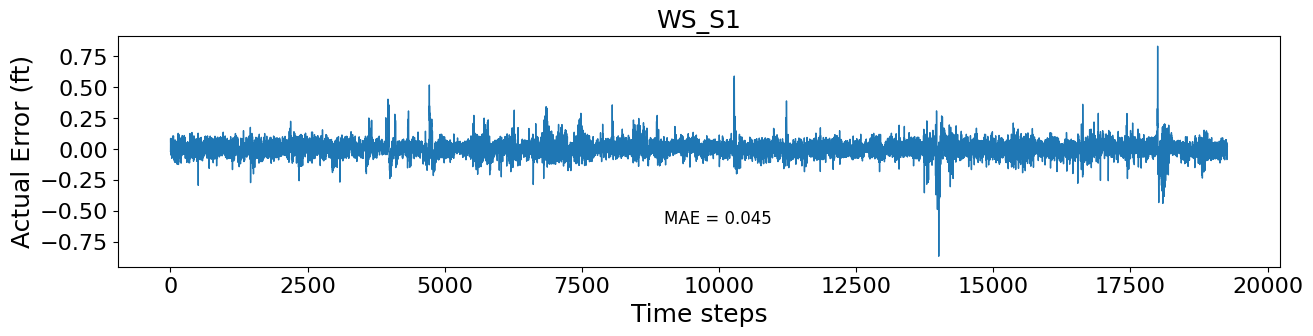

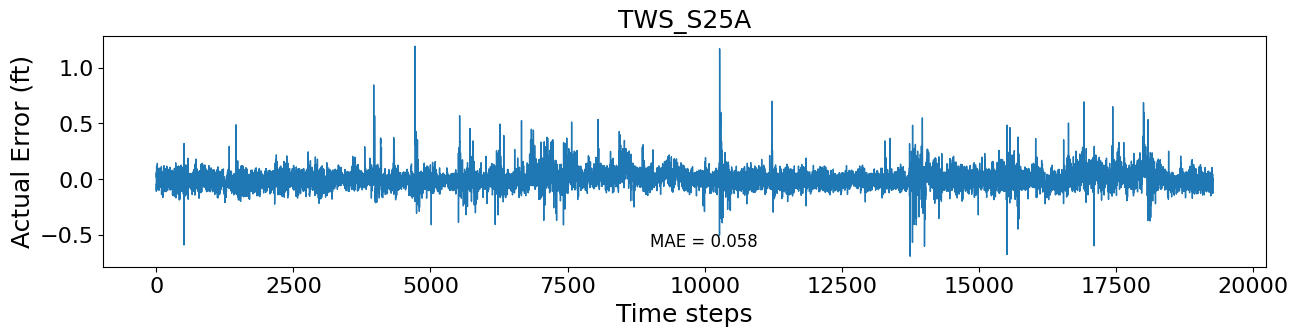

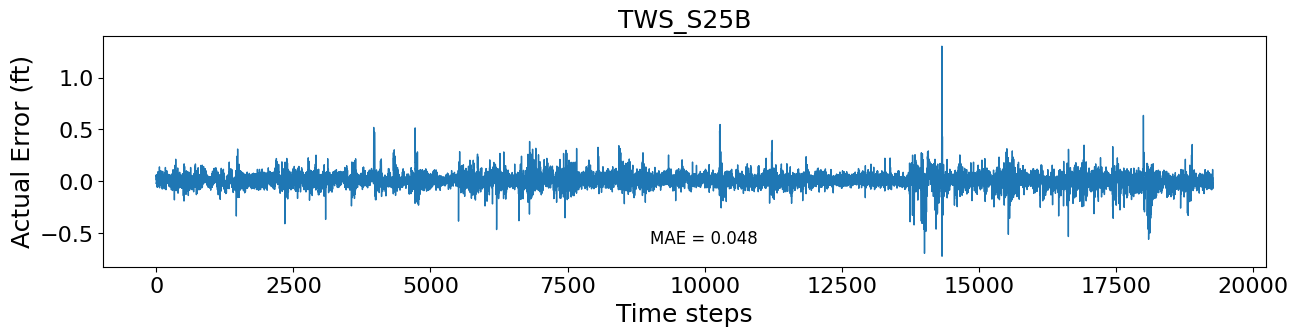

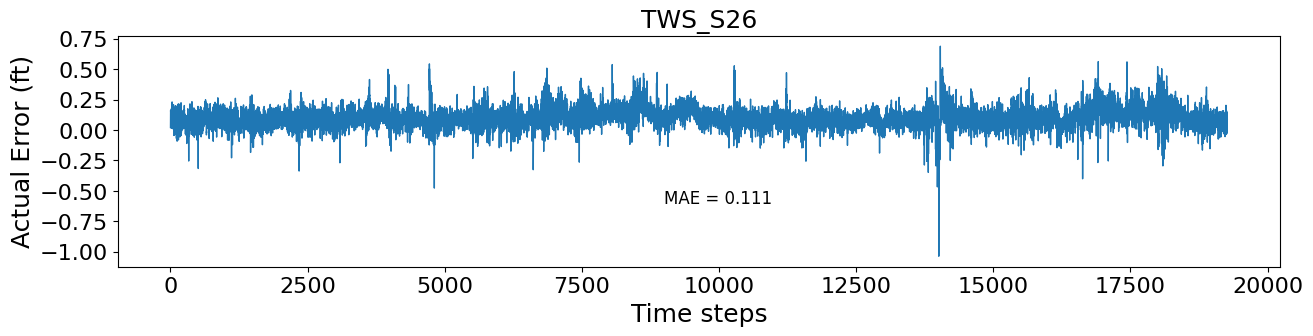

In [13]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [14]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
11
(19268,)
44
(19268,)
16
(19268,)
20


In [15]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
7
(19268,)
37
(19268,)
7
(19268,)
16


In [16]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
4
(19268,)
7
(19268,)
9
(19268,)
4
